## Mô hình dự đáo biến động giá cổ phiếu
Bài toán dự đoán biến động giá cổ phiếu sau N bước thời gian có thể quy về bài toán dự báo giá cổ phiếu sau N bước. Từ kết quả dự báo trừ cho quan sát hiện tại thu được biến động giá. 

Dữ liệu giá cổ phiếu là giữ liệu nhiều chiều với các thuộc tính close, open, high, low. Do lượng dữ liệu nhiều nên em sẽ sử dụng các mô hình học sâu cho bài toán dự báo chuỗi thời gian nhiều chiều. Các kiến trúc mô hình được sử dụng gồm:
- Autoformer
- RNN
- LSTM   

Mỗi mô hình sử dụng 100 quan sát đã biết để dự báo cho 100 quan sát tiếp theo và được huấn luyện với hàm mất mát MSE. Dữ liệu train, valid, test được chia với tỉ lệ 6:2:2. Dưới đây là bảng đánh giá MSE trên tập test của từng bộ dữ liệu:
|            | FPT      | MSN      | PNJ      | VIC      |
|------------|----------|----------|----------|----------|
| Autoformer | 0.2877   | 1.3778   | 0.6089   | 1.1862   |
| RNN        | 127.0026 | 218.2242 | 218.7786 | 286.1384 |
| LSTM       | 107.9635 | 249.2248 | 65.7064  | 63.6461  | 



In [67]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader 
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MyData(Dataset):
    def __init__(self,size, path, flag, col_input = [2,3,4,5,6], col_output = [2,3,4,5]):
        super().__init__()
        self.seq_len = size[0]
        self.lab_len = size[1]
        self.pred_len = size[2]
        self.col_input = col_input
        self.col_output = col_output
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        assert flag in ['train', 'test', 'valid']
        type_map = {'train': 0, 'valid': 1, 'test': 2}
        self.set_type = type_map[flag]
        self.path = path
        self.__read_data__()
    
    def __read_data__(self):     
        df_raw = pd.read_csv(self.path)
        border1s = [0, int(len(df_raw)*0.6) - self.seq_len, int(len(df_raw)* 0.8) - self.seq_len]
        border2s = [int(len(df_raw)*0.6), int(len(df_raw)*0.8), int(len(df_raw))]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]
        self.data_x = torch.tensor(df_raw[df_raw.columns[self.col_input]].values[border1:border2], dtype = torch.float32)
        self.data_y = torch.tensor(df_raw[df_raw.columns[self.col_output]].values[border1:border2], dtype = torch.float32)    
    def __getitem__(self, index):
        s_begin = index
        s_end = index + self.seq_len
        r_begin = s_end - self.lab_len
        r_end = r_begin + self.lab_len + self.pred_len
        seq_x = self.data_x[s_begin: s_end]
        seq_y = self.data_y[r_begin: r_end]
        return seq_x, seq_y, seq_x, seq_y
    
    def __len__(self):
        return len(self.data_x) -  self.seq_len - self.pred_len + 1    

### Mô hình Autoformer
Kiến trúc Autoformer được [Haixi Wu và các cộng sự](https://arxiv.org/pdf/2106.13008.pdf) đề xuất. Mô hình sử dụng kiến trúc của transformer nhưng thay các lớp multihead attention bởi các lớp autocorrelation và đánh bại các kiến trúc khác trên các bộ benchmark. Mã nguồn của kiến trúc có trên [github](https://github.com/thuml/Autoformer).

Em đã tinh chỉnh một vài chỗ trong mã nguồn để phù hợp với bộ dữ liệu và ý tưởng của bản thân. Mô hình Autoformer sử dụng năm trường open, high, low, close, volume của 100 quan sát trong quá khứ để dự báo cho 100 quan sát tương lai với các trường open, high, low, close. Các mô hình được huấn luyện với 20 epoch.    

In [3]:
class AutoCorrelation(nn.Module):
    """
    AutoCorrelation Mechanism with the following two phases:
    (1) period-based dependencies discovery
    (2) time delay aggregation
    This block can replace the self-attention family mechanism seamlessly.
    """
    def __init__(self, mask_flag=True, factor=1, scale=None, attention_dropout=0.1, output_attention=False):
        super(AutoCorrelation, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def time_delay_agg_training(self, values, corr):
        """
        SpeedUp version of Autocorrelation (a batch-normalization style design)
        This is for the training phase.
        """
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        index = torch.topk(torch.mean(mean_value, dim=0), top_k, dim=-1)[1]
        weights = torch.stack([mean_value[:, index[i]] for i in range(top_k)], dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            pattern = torch.roll(tmp_values, -int(index[i]), -1)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_inference(self, values, corr):
        """
        SpeedUp version of Autocorrelation (a batch-normalization style design)
        This is for the inference phase.
        """
        batch = values.shape[0]
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # index init
        init_index = torch.arange(length).unsqueeze(0).unsqueeze(0).unsqueeze(0)\
            .repeat(batch, head, channel, 1).to(values.device)
        # find top k
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        weights, delay = torch.topk(mean_value, top_k, dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            tmp_delay = init_index + delay[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_full(self, values, corr):
        """
        Standard version of Autocorrelation
        """
        batch = values.shape[0]
        head = values.shape[1]
        channel = values.shape[2]
        length = values.shape[3]
        # index init
        init_index = torch.arange(length).unsqueeze(0).unsqueeze(0).unsqueeze(0)\
            .repeat(batch, head, channel, 1).to(values.device)
        # find top k
        top_k = int(self.factor * math.log(length))
        weights, delay = torch.topk(corr, top_k, dim=-1)
        # update corr
        tmp_corr = torch.softmax(weights, dim=-1)
        # aggregation
        tmp_values = values.repeat(1, 1, 1, 2)
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            tmp_delay = init_index + delay[..., i].unsqueeze(-1)
            pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
            delays_agg = delays_agg + pattern * (tmp_corr[..., i].unsqueeze(-1))
        return delays_agg

    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        if L > S:
            zeros = torch.zeros_like(queries[:, :(L - S), :]).float()
            values = torch.cat([values, zeros], dim=1)
            keys = torch.cat([keys, zeros], dim=1)
        else:
            values = values[:, :L, :, :]
            keys = keys[:, :L, :, :]

        # period-based dependencies
        q_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
        res = q_fft * torch.conj(k_fft)
        corr = torch.fft.irfft(res, n=L, dim=-1)

        # time delay agg
        if self.training:
            V = self.time_delay_agg_training(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)
        else:
            V = self.time_delay_agg_inference(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)

        if self.output_attention:
            return (V.contiguous(), corr.permute(0, 3, 1, 2))
        else:
            return (V.contiguous(), None)


class AutoCorrelationLayer(nn.Module):
    def __init__(self, correlation, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AutoCorrelationLayer, self).__init__()
        device = 'cuda' if torch.cuda.is_available() else 'cpu' 
        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_correlation = correlation
        self.query_projection = nn.Linear(d_model, d_keys * n_heads, device = device)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads, device = device)
        self.value_projection = nn.Linear(d_model, d_values * n_heads, device = device)
        self.out_projection = nn.Linear(d_values * n_heads, d_model, device = device)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_correlation(
            queries,
            keys,
            values,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn


class my_Layernorm(nn.Module):
    """
    Special designed layernorm for the seasonal part
    """
    def __init__(self, channels):
        super(my_Layernorm, self).__init__()
        self.layernorm = nn.LayerNorm(channels, device= 'cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, x):
        x_hat = self.layernorm(x)
        bias = torch.mean(x_hat, dim=1).unsqueeze(1).repeat(1, x.shape[1], 1)
        return x_hat - bias
    
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x    
    
class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean    
    
class EncoderLayer(nn.Module):
    """
    Autoformer encoder layer with the progressive decomposition architecture
    """
    def __init__(self, attention, d_model, d_ff=None, moving_avg=25, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1, bias=False,  device= 'cuda' if torch.cuda.is_available() else 'cpu')
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1, bias=False,  device= 'cuda' if torch.cuda.is_available() else 'cpu')
        self.decomp1 = series_decomp(moving_avg)
        self.decomp2 = series_decomp(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        x = x + self.dropout(new_x)
        x, _ = self.decomp1(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        res, _ = self.decomp2(x + y)
        return res, attn    
    
class Encoder(nn.Module):
    """
    Autoformer encoder
    """
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns    
class DecoderLayer(nn.Module):
    """
    Autoformer decoder layer with the progressive decomposition architecture
    """
    def __init__(self, self_attention, cross_attention, d_model, c_out, d_ff=None,
                 moving_avg=25, dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1, bias=False,  device= 'cuda' if torch.cuda.is_available() else 'cpu')
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1, bias=False,  device= 'cuda' if torch.cuda.is_available() else 'cpu')
        self.decomp1 = series_decomp(moving_avg)
        self.decomp2 = series_decomp(moving_avg)
        self.decomp3 = series_decomp(moving_avg)
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Conv1d(in_channels=d_model, out_channels=c_out, kernel_size=3, stride=1, padding=1,
                                    padding_mode='circular', bias=False,  device= 'cuda' if torch.cuda.is_available() else 'cpu')
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x, trend1 = self.decomp1(x)
        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])
        x, trend2 = self.decomp2(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        x, trend3 = self.decomp3(x + y)

        residual_trend = trend1 + trend2 + trend3
        residual_trend = self.projection(residual_trend.permute(0, 2, 1)).transpose(1, 2)
        return x, residual_trend


class Decoder(nn.Module):
    """
    Autoformer encoder
    """
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, trend=None):
        for layer in self.layers:
            x, residual_trend = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)
            trend = trend + residual_trend

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x, trend    
    
    
    

In [4]:
class Model(nn.Module):
    """
    Autoformer is the first method to achieve the series-wise connection,
    with inherent O(LlogL) complexity
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.pred_len = configs.pred_len
        self.output_attention = configs.output_attention
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.linear1 = nn.Linear(in_features= configs.c_in, out_features= configs.d_model, bias = True, device= 'cuda' if torch.cuda.is_available() else 'cpu' )
        self.linear2 = nn.Linear(in_features= configs.c_in, out_features= configs.d_model, bias = True,  device= 'cuda' if torch.cuda.is_available() else 'cpu')
        self.linear3 = nn.Linear(in_features= configs.c_in, out_features= configs.c_out, bias = True,  device= 'cuda' if torch.cuda.is_available() else 'cpu')    
        # Decomp
        kernel_size = configs.moving_avg
        self.decomp = series_decomp(kernel_size)

        # Embedding
        # The series-wise connection inherently contains the sequential information.
        # Thus, we can discard the position embedding of transformers.
        
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(False, configs.factor, attention_dropout=configs.dropout,
                                        output_attention=configs.output_attention),
                        configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.d_ff,
                    moving_avg=configs.moving_avg,
                    dropout=configs.dropout,
                    activation=configs.activation
                ) for l in range(configs.e_layers)
            ],
            norm_layer=my_Layernorm(configs.d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(True, configs.factor, attention_dropout=configs.dropout,
                                        output_attention=False),
                        configs.d_model, configs.n_heads),
                    AutoCorrelationLayer(
                        AutoCorrelation(False, configs.factor, attention_dropout=configs.dropout,
                                        output_attention=False),
                        configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.c_out,
                    configs.d_ff,
                    moving_avg=configs.moving_avg,
                    dropout=configs.dropout,
                    activation=configs.activation,
                )
                for l in range(configs.d_layers)
            ],
            norm_layer=my_Layernorm(configs.d_model),
            projection=nn.Linear(configs.d_model, configs.c_out, bias=True)
        )

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        # decomp init
        mean = torch.mean(x_enc, dim=1).unsqueeze(1).repeat(1, self.pred_len, 1)
        zeros = torch.zeros([x_enc.shape[0], self.pred_len, x_enc.shape[2]], device=x_enc.device)
        seasonal_init, trend_init = self.decomp(x_enc)
        # decoder input
        trend_init = torch.cat([trend_init[:, -self.label_len:, :], mean], dim=1)
        seasonal_init = torch.cat([seasonal_init[:, -self.label_len:, :], zeros], dim=1)
        # enc
        x_enc = self.linear1(x_enc)
        enc_out, attns = self.encoder(x_enc, attn_mask=enc_self_mask)
        # dec
        seasonal_init = self.linear2(seasonal_init)
        trend_init = self.linear3(trend_init)
        seasonal_part, trend_part = self.decoder(seasonal_init, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask,
                                                 trend=trend_init)
        # final
        dec_out = trend_part + seasonal_part

        if self.output_attention:
            return dec_out[:, -self.pred_len:, :], attns
        else:
            return dec_out[:, -self.pred_len:, :]  # [B, L, D]
        
def predict(model, batch_x, batch_y, batch_x_mark, batch_y_mark):
        dec_inp = torch.zeros_like(batch_y[:, -model.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :model.label_len, :], dec_inp], dim=1).float().to(model.device)     
        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        outputs = outputs[:, -model.pred_len:, :]
        batch_y = batch_y[:, -model.pred_len:, :].to(model.device)
        return outputs, batch_y    
def valid(model,vali_loader, loss_fn):
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    total_loss = []
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float()

            batch_x_mark = batch_x_mark.float().to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            outputs, batch_y = predict(model,batch_x, batch_y, batch_x_mark, batch_y_mark)

            pred = outputs.detach().cpu()
            true = batch_y.detach().cpu()
            loss = loss_fn(pred, true)
            total_loss.append(loss)
    total_loss = np.average(total_loss)
    model.train()
    return total_loss                        

In [28]:
def train(model, optimizer,datapath, loss_fn, configs, epoch = 20,batch_size = 64):
    data_train = MyData(size = [configs.seq_len, configs.label_len, configs.pred_len],path = datapath,flag = 'train')
    data_test = MyData(size = [configs.seq_len, configs.label_len, configs.pred_len],path = datapath,flag = 'test' )
    data_valid = MyData(size = [configs.seq_len, configs.label_len, configs.pred_len],path = datapath,flag = 'valid')
    data_train = DataLoader(data_train, batch_size= batch_size, shuffle = True)
    data_test = DataLoader(data_test, batch_size= batch_size, shuffle = False)
    data_valid = DataLoader(data_valid, batch_size= batch_size, shuffle = False)
    model.train()   
    scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) 
    tmp = 0
    for i in range(epoch):
        train_loss = [] 
        for j, (seq_x, seq_y, seq_z, seq_t) in enumerate(data_train):
            optimizer.zero_grad()
            outputs, seq_y = predict(model, seq_x, seq_y, seq_z, seq_t)
            loss = loss_fn(outputs, seq_y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            if (j+1)%100 == 0:
                print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(j + 1, i + 1, loss.item()))
        scheduler1.step()    
        train_loss = np.average(train_loss)
        Valos = valid(model, data_valid, loss_fn)
        Telos = valid(model, data_test, loss_fn)     
        print("Epoch: {0} | Train Loss: {1:.7f} Vali Loss: {2:.7f} Test Loss: {3:.7f}".format(
                i + 1, train_loss, Valos, Telos))    
               
                    

In [6]:
import argparse
parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')  

parser.add_argument('--seq_len', type = int, default = 100,help = 'input sequence length')
parser.add_argument('--label_len', type = int,default = 50, help  = 'start token length')
parser.add_argument('--pred_len', type = int, default = 100, help = 'prediction sequence length')
parser.add_argument('--c_out', type = int, default = 4, help = 'output size')
parser.add_argument('--c_in', type = int, default = 5, help = 'input size')
parser.add_argument('--moving_avg', type = int,default = 15, help = 'window size')
parser.add_argument('--output_attention', type = bool, default = False)
parser.add_argument('--n_heads', type = int, default = 8)
parser.add_argument('--d_model', type = int, default = 20)
parser.add_argument('--e_layers', type = int, default = 2 )
parser.add_argument('--d_layers', type = int, default = 1)
parser.add_argument('--d_ff', type = int, default = 80)
parser.add_argument('--factor', type = int, default = 1)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')#dropout
parser.add_argument('--activation', type=str, default='gelu', help='activation')
config = parser.parse_args(args = [])

In [ ]:
model  = Model(config)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train(model, optimizer, 'data/FPT.csv', nn.MSELoss(), config)
torch.save(model.state_dict(), 'Auto_FPT.pth')

In [ ]:
model  = Model(config)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train(model, optimizer, 'data/MSN.csv', nn.MSELoss(), config)
torch.save(model.state_dict(), 'Auto_MSN.pth')

In [ ]:
model  = Model(config)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train(model, optimizer, 'data/PNJ.csv', nn.MSELoss(), config)
torch.save(model.state_dict(), 'Auto_PNJ.pth')

In [ ]:
model  = Model(config)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train(model, optimizer, 'data/VIC.csv', nn.MSELoss(), config)
torch.save(model.state_dict(), 'Auto_VIC.pth')

### Mô hình RNN và LSTM
Sử dụng chuỗi có độ dài seq_len = 100, dự báo 100 quan sát tiếp theo (pred_len = 100).  
Các mô hình RNN huấn luyện với 20 epochs, các mô hình LSTM sẽ huấn luyện ít epoch hơn do trình trạng overfit.

In [91]:
class MyLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers,seq_len = 100, pred_len= 100):
        super().__init__()
        self.pred_len = pred_len
        self.seq_len = seq_len 
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, device = 'cuda' if torch.cuda.is_available() else 'cpu')
        self.fc = nn.Linear(hidden_dim,input_dim)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out)[:, -1:, :]  # chỉ lấy output ở time step cuối cùng
        tmp = out
        for i in range(self.pred_len -1):
            out1, (hn, cn) = self.lstm(tmp, (hn, cn))
            out1 = self.fc(out1)
            out = torch.cat([out, out1], dim = 1)
            tmp = out1
        return out 
    
class MyRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers,seq_len = 100, pred_len= 100):
        super().__init__()
        self.pred_len = pred_len
        self.seq_len = seq_len 
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers,batch_first=True,dropout = 0.05, device = 'cuda' if torch.cuda.is_available() else 'cpu', nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim,input_dim)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
        out, hn = self.rnn(x, h0)
        out = self.fc(out)[:, -1:, :]  # chỉ lấy output ở time step cuối cùng
        tmp = out
        for i in range(self.pred_len -1):
            out1, hn = self.rnn(tmp, hn)
            out1 = self.fc(out1)
            out = torch.cat([out, out1], dim = 1)
            tmp = out1
        return out     

def predict_RNN(model, batch_x, batch_y):
    true  = batch_y[:, -model.pred_len:, :].to(model.device)
    pred = model(batch_x).to(model.device)
    return pred, true

def train_RNN(model, optimizer, datapath,loss_fn, epoch = 20, batch_size = 64):
    data_train = MyData(size = [model.seq_len, 1, model.pred_len],path = datapath,flag = 'train', col_input= [ 2,3,4,5])
    data_test = MyData(size = [model.seq_len, 1, model.pred_len],path = datapath,flag = 'test' , col_input = [2,3,4,5])
    data_valid = MyData(size = [model.seq_len, 1, model.pred_len],path = datapath,flag = 'valid', col_input= [2,3,4,5])
    data_train = DataLoader(data_train, batch_size= batch_size, shuffle = True)
    data_test = DataLoader(data_test, batch_size= batch_size, shuffle = False)
    data_valid = DataLoader(data_valid, batch_size= batch_size, shuffle = False)
    model.train()   
    scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) 
    tmp = 0
    for i in range(epoch):
        train_loss = [] 
        for j, (seq_x, seq_y, seq_z, seq_t) in enumerate(data_train):
            optimizer.zero_grad()
            outputs, seq_y = predict_RNN(model, seq_x, seq_y)
            loss = loss_fn(outputs, seq_y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            if (j+1)%100 == 0:
                print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(j + 1, i + 1, loss.item()))
        scheduler1.step()    
        train_loss = np.average(train_loss)
        Valos = valid_RNN(model, data_valid, loss_fn)
        Telos = valid_RNN(model, data_test, loss_fn)     
        print("Epoch: {0} | Train Loss: {1:.7f} Vali Loss: {2:.7f} Test Loss: {3:.7f}".format(
                i + 1, train_loss, Valos, Telos))    
           
def valid_RNN(model,vali_loader, loss_fn):
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    total_loss = []
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            outputs, batch_y = predict_RNN(model,batch_x, batch_y)
            pred = outputs.detach().cpu()
            true = batch_y.detach().cpu()
            loss = loss_fn(pred, true)
            total_loss.append(loss)
    total_loss = np.average(total_loss)
    model.train()
    return total_loss            

In [ ]:
model = MyRNN(input_dim = 4, hidden_dim = 20, num_layers = 3)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train_RNN(model, optimizer, 'data/FPT.csv', nn.MSELoss())
torch.save(model.state_dict(), 'RNN_FPT.pth')


In [36]:
model = MyRNN(input_dim = 4, hidden_dim = 20, num_layers = 3)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train_RNN(model, optimizer, 'data/PNJ.csv', nn.MSELoss())
torch.save(model.state_dich(), 'RNN_PNJ.path')

In [38]:
model = MyRNN(input_dim = 4, hidden_dim = 20, num_layers = 3)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train_RNN(model, optimizer, 'data/MSN.csv', nn.MSELoss())
torch.save(model.state_dich(), 'RNN_MSN.path')

	iters: 100, epoch: 1 | loss: 6622.4335938
	iters: 200, epoch: 1 | loss: 583.0628052
	iters: 300, epoch: 1 | loss: 178.7241821
	iters: 400, epoch: 1 | loss: 163.8155823
	iters: 500, epoch: 1 | loss: 114.2703247
	iters: 600, epoch: 1 | loss: 104.1965790
	iters: 700, epoch: 1 | loss: 98.9813461
	iters: 800, epoch: 1 | loss: 92.8153992
	iters: 900, epoch: 1 | loss: 76.4600830
	iters: 1000, epoch: 1 | loss: 82.0717316
	iters: 1100, epoch: 1 | loss: 117.1894836
	iters: 1200, epoch: 1 | loss: 73.7060852
Epoch: 1 | Train Loss: 844.5808205 Vali Loss: 36.1170273 Test Loss: 120.7970123
	iters: 100, epoch: 2 | loss: 74.9657898
	iters: 200, epoch: 2 | loss: 78.8224106
	iters: 300, epoch: 2 | loss: 56.8160706
	iters: 400, epoch: 2 | loss: 63.8375206
	iters: 500, epoch: 2 | loss: 57.6279106
	iters: 600, epoch: 2 | loss: 71.9108276
	iters: 700, epoch: 2 | loss: 63.4866905
	iters: 800, epoch: 2 | loss: 68.6710281
	iters: 900, epoch: 2 | loss: 64.1615372
	iters: 1000, epoch: 2 | loss: 45.2296181
	iters

In [39]:
model = MyRNN(input_dim = 4, hidden_dim = 20, num_layers = 3)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train_RNN(model, optimizer, 'data/VIC.csv', nn.MSELoss())
torch.save(model.state_dict(), 'RNN_VIC.pth')

In [42]:
model = MyLSTM(input_dim = 4, hidden_dim = 20, num_layers = 3)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train_RNN(model, optimizer, 'data/PNJ.csv', nn.MSELoss(), epoch = 4)
torch.save(model.state_dict(), 'LSTM_PNJ.pth')

	iters: 100, epoch: 1 | loss: 5613.9194336
	iters: 200, epoch: 1 | loss: 5047.3032227
	iters: 300, epoch: 1 | loss: 4794.2011719
	iters: 400, epoch: 1 | loss: 4419.8500977
	iters: 500, epoch: 1 | loss: 4162.2441406
	iters: 600, epoch: 1 | loss: 3754.7656250
	iters: 700, epoch: 1 | loss: 3593.7434082
	iters: 800, epoch: 1 | loss: 3605.7614746
	iters: 900, epoch: 1 | loss: 3249.2385254
	iters: 1000, epoch: 1 | loss: 2874.4970703
	iters: 1100, epoch: 1 | loss: 2727.0830078
Epoch: 1 | Train Loss: 4011.4997946 Vali Loss: 2099.0446777 Test Loss: 1618.6068115
	iters: 100, epoch: 2 | loss: 2416.5615234
	iters: 200, epoch: 2 | loss: 2464.5654297
	iters: 300, epoch: 2 | loss: 2147.6345215
	iters: 400, epoch: 2 | loss: 2230.4106445
	iters: 500, epoch: 2 | loss: 1930.6160889
	iters: 600, epoch: 2 | loss: 1909.6711426
	iters: 700, epoch: 2 | loss: 1672.3828125
	iters: 800, epoch: 2 | loss: 1574.6566162
	iters: 900, epoch: 2 | loss: 1406.9144287
	iters: 1000, epoch: 2 | loss: 1335.0128174
	iters: 11

In [ ]:
model = MyLSTM(input_dim = 4, hidden_dim = 20, num_layers = 3)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train_RNN(model, optimizer, 'data/FPT.csv', nn.MSELoss(), epoch = 4)
torch.save(model.state_dict(), 'LSTM_FPT.pth')

In [ ]:
model = MyLSTM(input_dim = 4, hidden_dim = 20, num_layers = 3)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train_RNN(model, optimizer, 'data/MSN.csv', nn.MSELoss(), epoch = 4)
torch.save(model.state_dict(), 'LSTM_MSN.pth')

In [ ]:
model = MyLSTM(input_dim = 4, hidden_dim = 20, num_layers = 3)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train_RNN(model, optimizer, 'data/VIC.csv', nn.MSELoss(), epoch = 4)
torch.save(model.state_dict(), 'LSTM_VIC.pth')

### Load model và tính toán trên tập data test.

In [186]:
def plot(pred, pred1, pred2, true):
    fig, axs = plt.subplots(2,2, figsize = (20,16))
    name = ['open', 'high', 'low', 'close']
    k = 0
    for i in range(0,2):
        for j in range(0,2):    
            axs[i][j].plot(pred[:,k], linestyle='-', label = 'Autoformer')
            axs[i][j].plot(pred1[:,k],  linestyle='-', label = 'RNN')
            axs[i][j].plot(pred2[:,k], linestyle='-', label = 'LSTM')
            axs[i][j].plot(true[:,k],  linestyle='-', label = 'Thực tế')       
            axs[i][j].set_title(name[k])                 
            axs[i][j].legend()
            k +=1 
    fig.suptitle('Đồ thị giá cổ phiếu dự báo và thực tế')     

In [187]:
data_test1 = DataLoader(MyData(size = [100, 50, 100], path='data/FPT.csv', flag = 'test'), batch_size= 64)
model1 = Model(config)
model1.load_state_dict(torch.load('Auto_FPT.pth'))
print(f"Sai số MSE trên tập test {valid(model1, data_test1, nn.MSELoss())}")

Sai số MSE trên tập test 0.28776639699935913


In [188]:
data_test2 = DataLoader(MyData(size = [100, 1, 100], path='data/FPT.csv', flag = 'test', col_input=[2,3,4,5]), batch_size= 64)
model2 = MyRNN(4, 20, 3)
model2.load_state_dict(torch.load('RNN_FPT.pth'))
print(f"Sai số MSE trên tập test {valid_RNN(model2, data_test2, nn.MSELoss())}")

Sai số MSE trên tập test 127.00263214111328


In [189]:
data_test2 = DataLoader(MyData(size = [100, 1, 100], path='data/FPT.csv', flag = 'test', col_input=[2,3,4,5]), batch_size= 64)
model3 = MyLSTM(4, 20, 3)
model3.load_state_dict(torch.load('LSTM_FPT.pth'))
print(f"Sai số MSE trên tập test {valid_RNN(model3, data_test2, nn.MSELoss())}")

Sai số MSE trên tập test 107.96351623535156


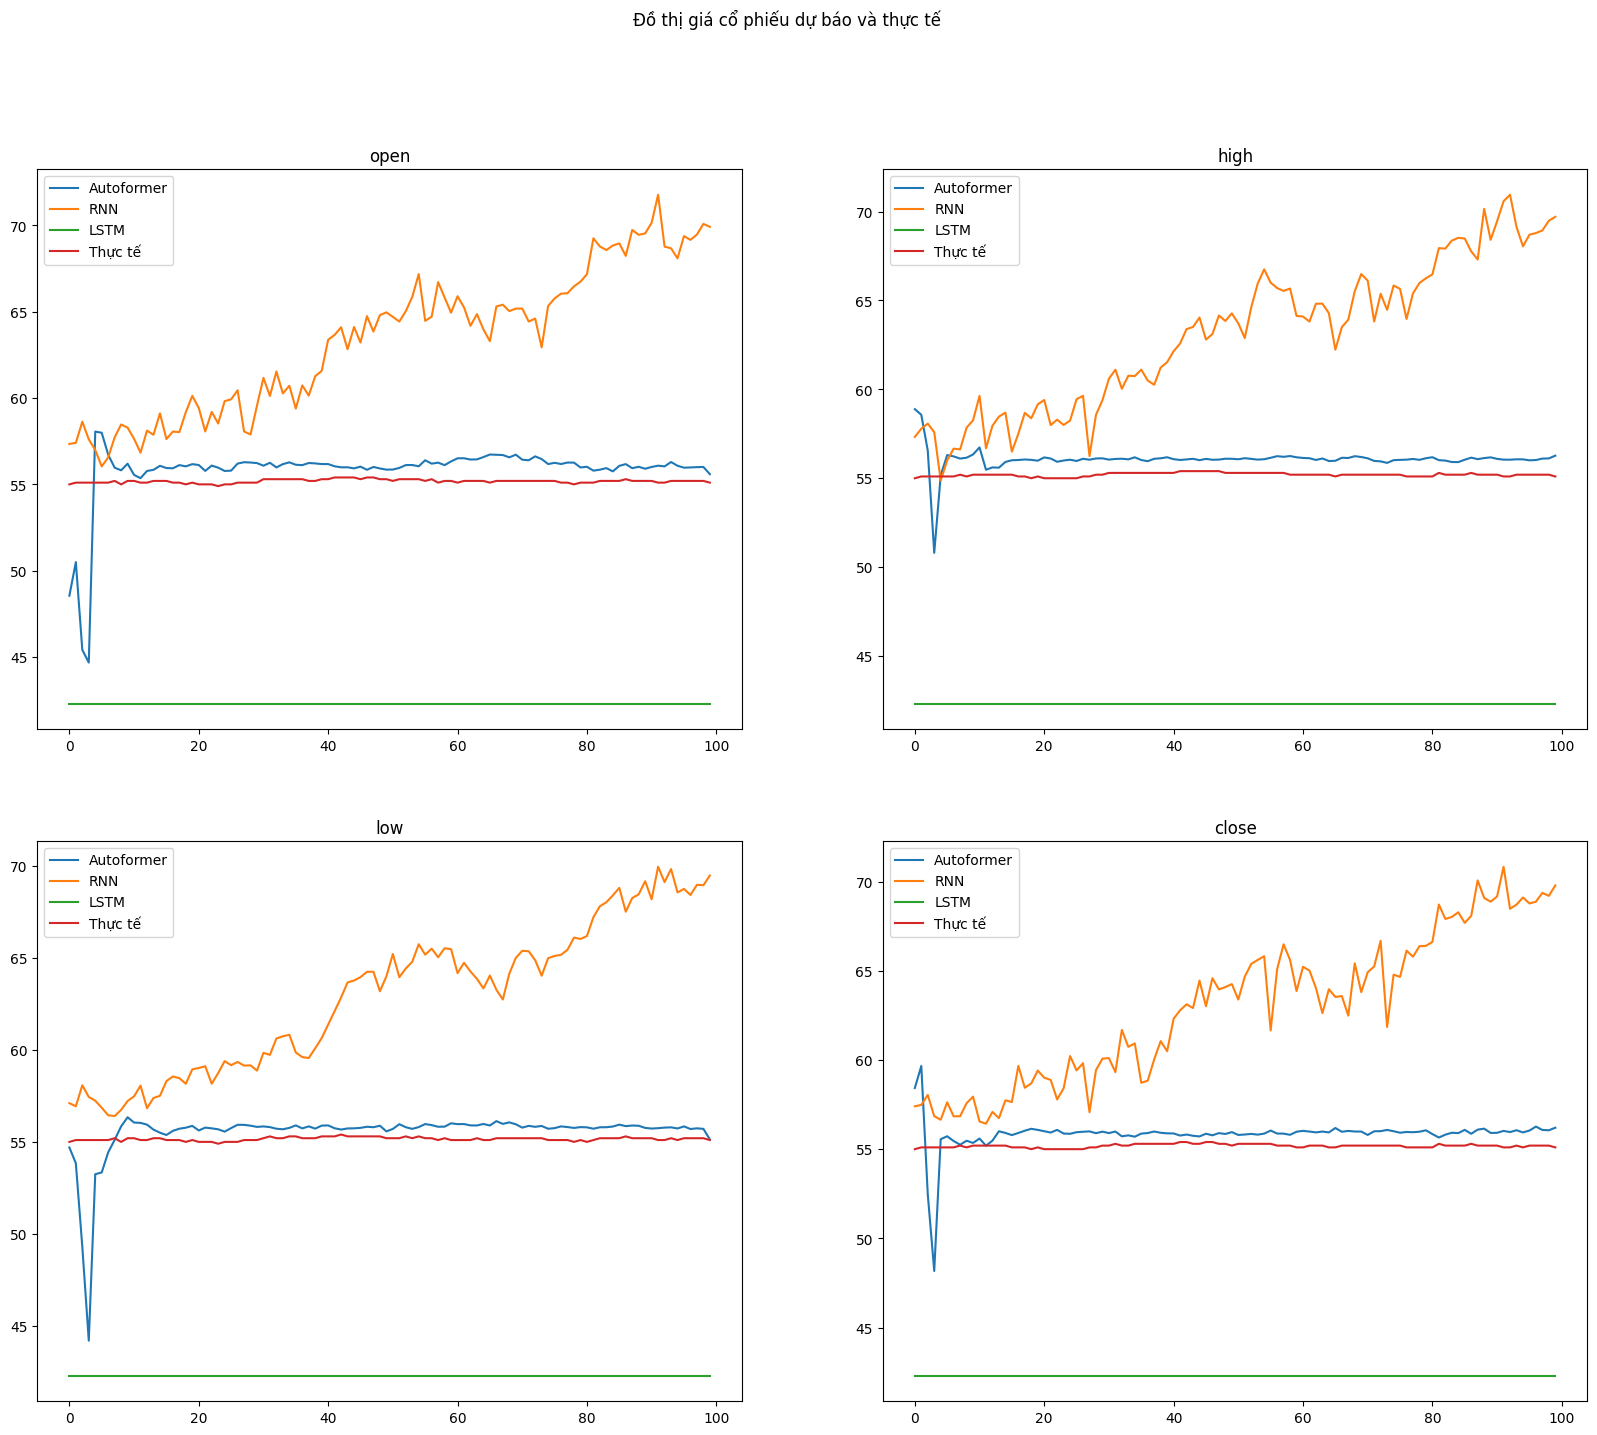

In [190]:
x = data_test1.dataset[16100]
y = data_test2.dataset[16100]
with torch.no_grad():
    pred1 = model1(x[0].unsqueeze(0),x[2].unsqueeze(0), x[1].unsqueeze(0), x[3].unsqueeze(0)).squeeze(0)
    #pred1 = pred1[1:, :] - pred1[:-1,:]
    pred2 = model2(y[0].unsqueeze(0)).squeeze(0)
    #pred2 = pred2[1:, :] - pred2[:-1,:]
    pred3 = model3(y[0].unsqueeze(0)).squeeze(0)
    #pred3 = pred3[1:, :] - pred3[:-1,:]
true = x[1][-100:, : ] #-  x[1][-99:, : ]
plot(pred1, pred2, pred3, true) 

In [191]:
data_test1 = DataLoader(MyData(size = [100, 50, 100], path='data/MSN.csv', flag = 'test'), batch_size= 64)
model1 = Model(config)
model1.load_state_dict(torch.load('Auto_MSN.pth'))
print(f"Sai số MSE trên tập test {valid(model1, data_test1, nn.MSELoss())}")

Sai số MSE trên tập test 1.3778599500656128


In [192]:
data_test2 = DataLoader(MyData(size = [100, 1, 100], path='data/MSN.csv', flag = 'test', col_input=[2,3,4,5]), batch_size= 64)
model2 = MyRNN(4, 20, 3)
model2.load_state_dict(torch.load('RNN_MSN.pth'))
print(f"Sai số MSE trên tập test {valid_RNN(model2, data_test2, nn.MSELoss())}")

Sai số MSE trên tập test 218.22427368164062


In [193]:
data_test2 = DataLoader(MyData(size = [100, 1, 100], path='data/MSN.csv', flag = 'test', col_input=[2,3,4,5]), batch_size= 64)
model3 = MyLSTM(4, 20, 3)
model3.load_state_dict(torch.load('LSTM_MSN.pth'))
print(f"Sai số MSE trên tập test {valid_RNN(model3, data_test2, nn.MSELoss())}")

Sai số MSE trên tập test 249.2248992919922


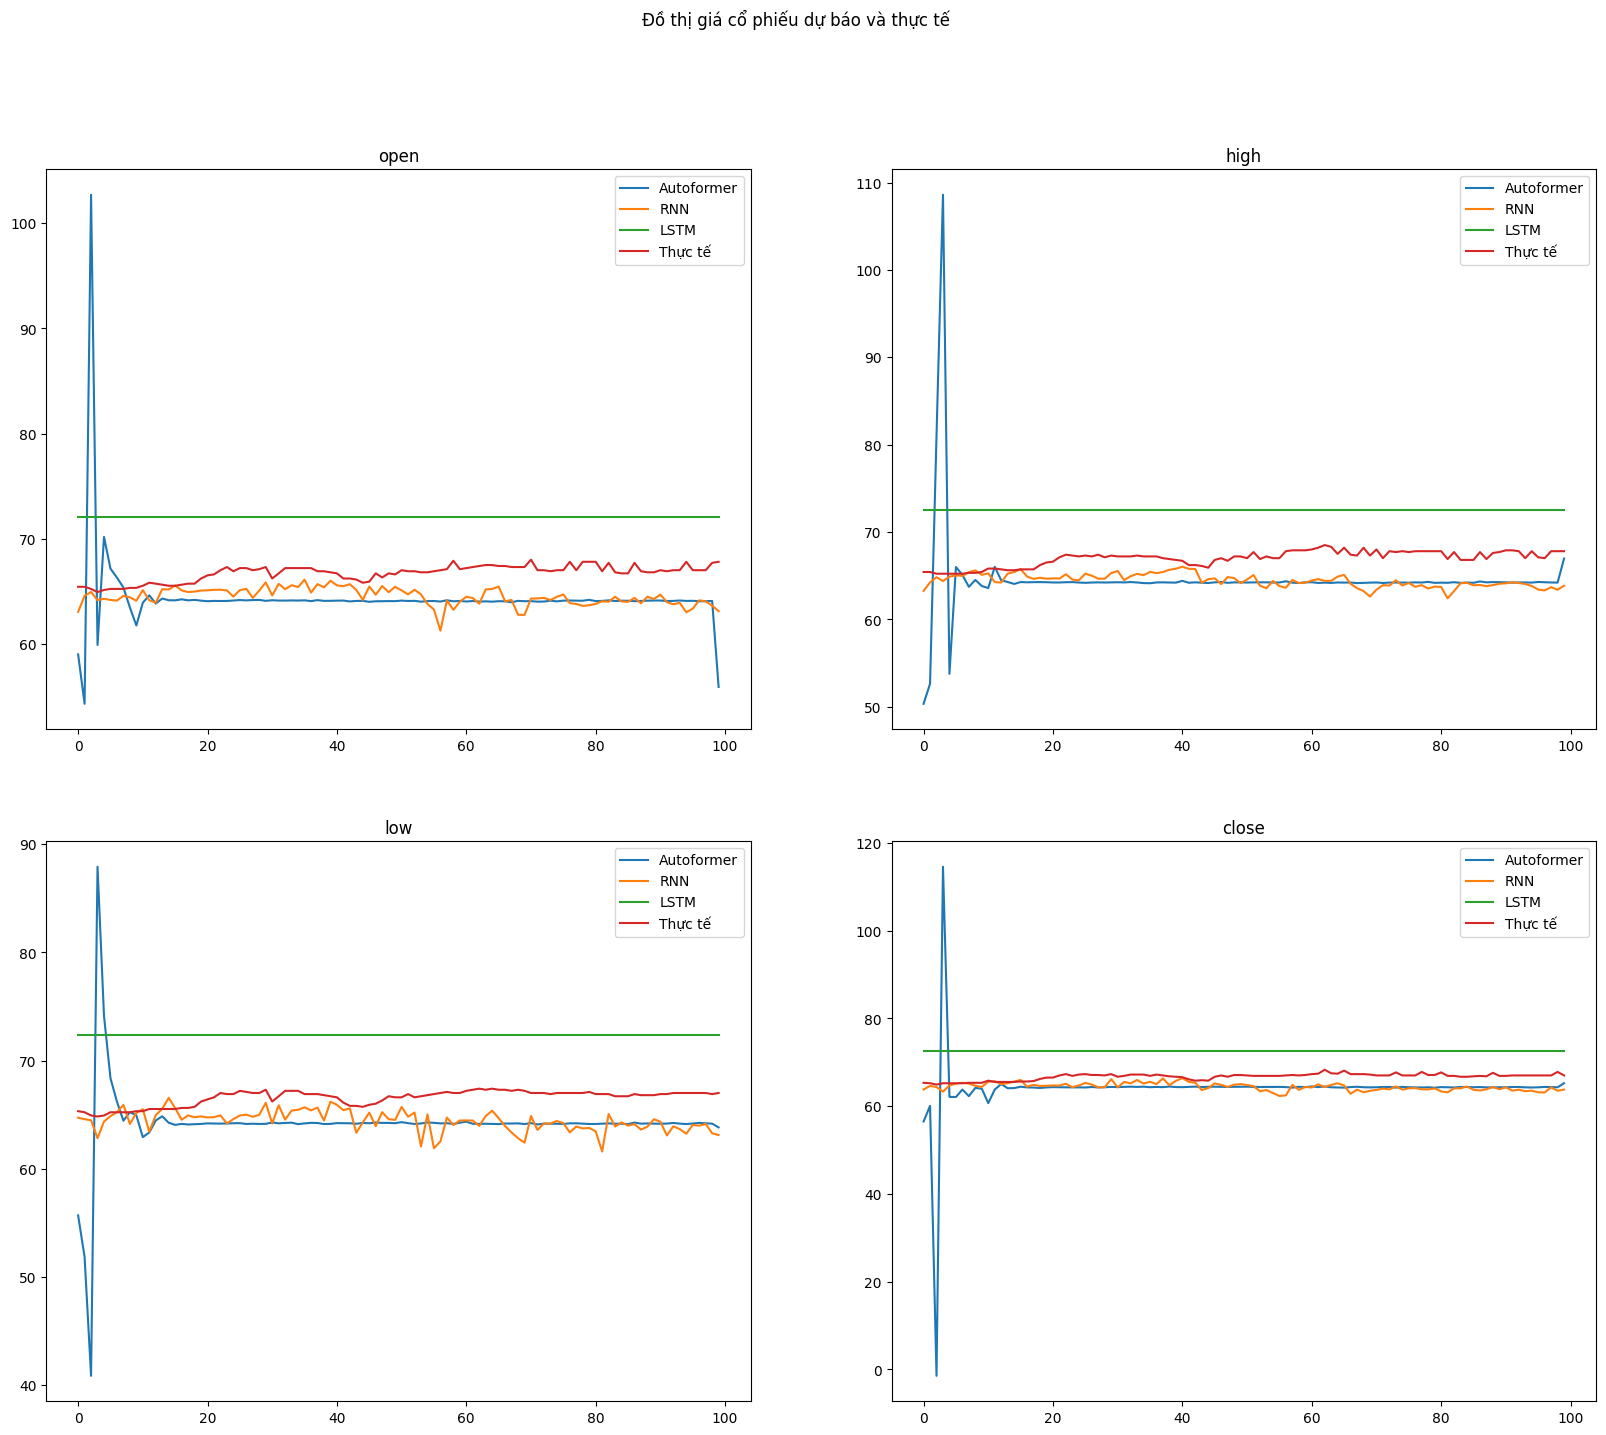

In [194]:
x = data_test1.dataset[16100]
y = data_test2.dataset[16100]
with torch.no_grad():
    pred1 = model1(x[0].unsqueeze(0),x[2].unsqueeze(0), x[1].unsqueeze(0), x[3].unsqueeze(0)).squeeze(0)
    #pred1 = pred1[1:, :] - pred1[:-1,:]
    pred2 = model2(y[0].unsqueeze(0)).squeeze(0)
    #pred2 = pred2[1:, :] - pred2[:-1,:]
    pred3 = model3(y[0].unsqueeze(0)).squeeze(0)
    #pred3 = pred3[1:, :] - pred3[:-1,:]
true = x[1][-100:, : ] #-  x[1][-99:, : ]
plot(pred1, pred2, pred3, true) 

In [203]:
data_test1 = DataLoader(MyData(size = [100, 50, 100], path='data/PNJ.csv', flag = 'test'), batch_size= 64)
model1 = Model(config)
model1.load_state_dict(torch.load('Auto_PNJ.pth'))
print(f"Sai số MSE trên tập test {valid(model1, data_test1, nn.MSELoss())}")

Sai số MSE trên tập test 0.6089911460876465


In [204]:
data_test2 = DataLoader(MyData(size = [100, 1, 100], path='data/PNJ.csv', flag = 'test', col_input=[2,3,4,5]), batch_size= 64)
model2 = MyRNN(4, 20, 3)
model2.load_state_dict(torch.load('RNN_PNJ.pth'))
print(f"Sai số MSE trên tập test {valid_RNN(model2, data_test2, nn.MSELoss())}")

Sai số MSE trên tập test 218.7786865234375


In [205]:
data_test2 = DataLoader(MyData(size = [100, 1, 100], path='data/PNJ.csv', flag = 'test', col_input=[2,3,4,5]), batch_size= 64)
model3 = MyLSTM(4, 20, 3)
model3.load_state_dict(torch.load('LSTM_PNJ.pth'))
print(f"Sai số MSE trên tập test {valid_RNN(model3, data_test2, nn.MSELoss())}")

Sai số MSE trên tập test 65.70642852783203


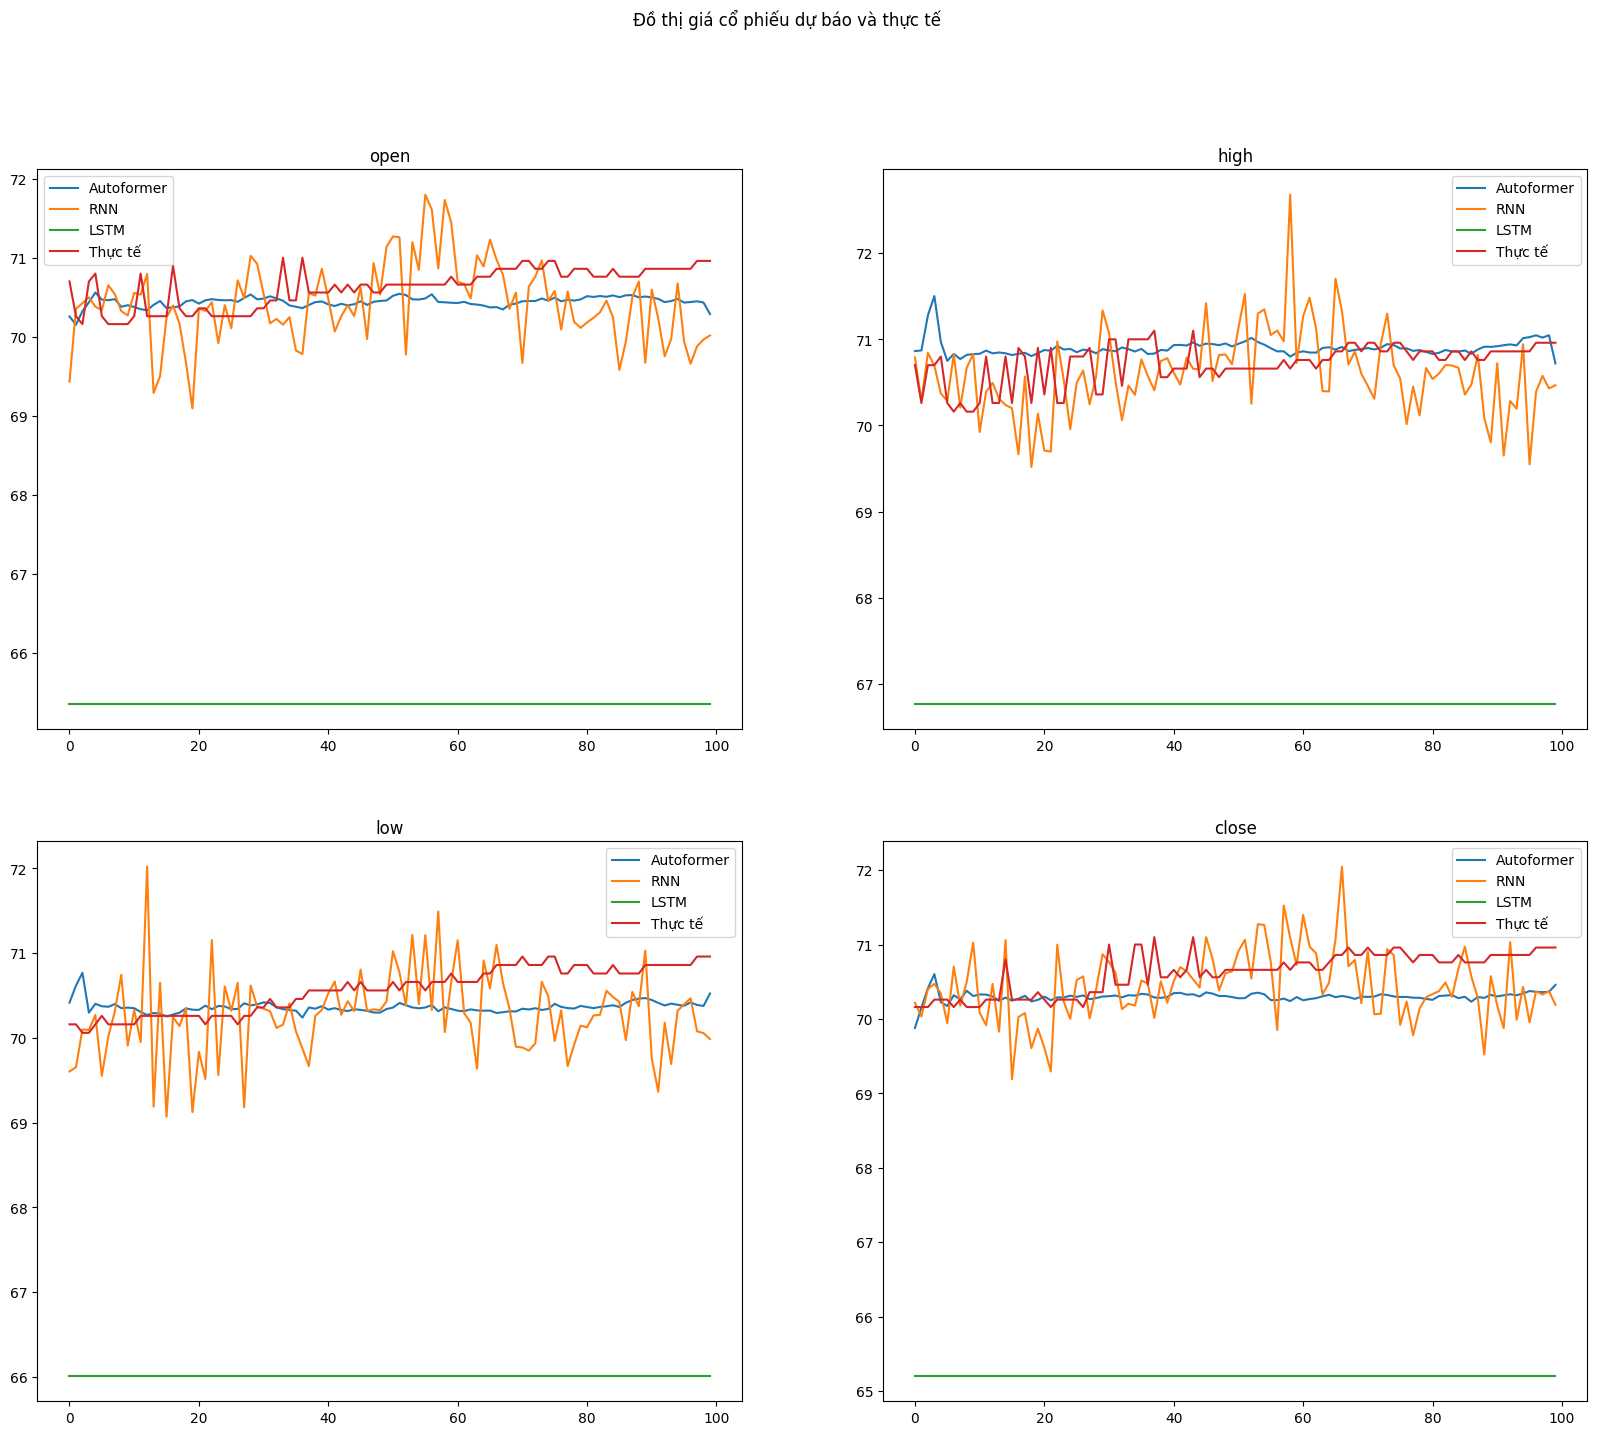

In [211]:
x = data_test1.dataset[18100]
y = data_test2.dataset[18100]
with torch.no_grad():
    pred1 = model1(x[0].unsqueeze(0),x[2].unsqueeze(0), x[1].unsqueeze(0), x[3].unsqueeze(0)).squeeze(0)
    #pred1 = pred1[1:, :] - pred1[:-1,:]
    pred2 = model2(y[0].unsqueeze(0)).squeeze(0)
    #pred2 = pred2[1:, :] - pred2[:-1,:]
    pred3 = model3(y[0].unsqueeze(0)).squeeze(0)
    #pred3 = pred3[1:, :] - pred3[:-1,:]
true = x[1][-100:, : ] #-  x[1][-99:, : ] 
plot(pred1, pred2, pred3, true) 

In [199]:
data_test1 = DataLoader(MyData(size = [100, 50, 100], path='data/VIC.csv', flag = 'test'), batch_size= 64)
model1 = Model(config)
model1.load_state_dict(torch.load('Auto_VIC.pth'))
print(f"Sai số MSE trên tập test {valid(model1, data_test1, nn.MSELoss())}")

Sai số MSE trên tập test 1.1862872838974


In [200]:
data_test2 = DataLoader(MyData(size = [100, 1, 100], path='data/VIC.csv', flag = 'test', col_input=[2,3,4,5]), batch_size= 64)
model2 = MyRNN(4, 20, 3)
model2.load_state_dict(torch.load('RNN_VIC.pth'))
print(f"Sai số MSE trên tập test {valid_RNN(model2, data_test2, nn.MSELoss())}")

Sai số MSE trên tập test 286.1384582519531


In [201]:
data_test2 = DataLoader(MyData(size = [100, 1, 100], path='data/VIC.csv', flag = 'test', col_input=[2,3,4,5]), batch_size= 64)
model3 = MyLSTM(4, 20, 3)
model3.load_state_dict(torch.load('LSTM_VIC.pth'))
print(f"Sai số MSE trên tập test {valid_RNN(model3, data_test2, nn.MSELoss())}")

Sai số MSE trên tập test 63.64614486694336


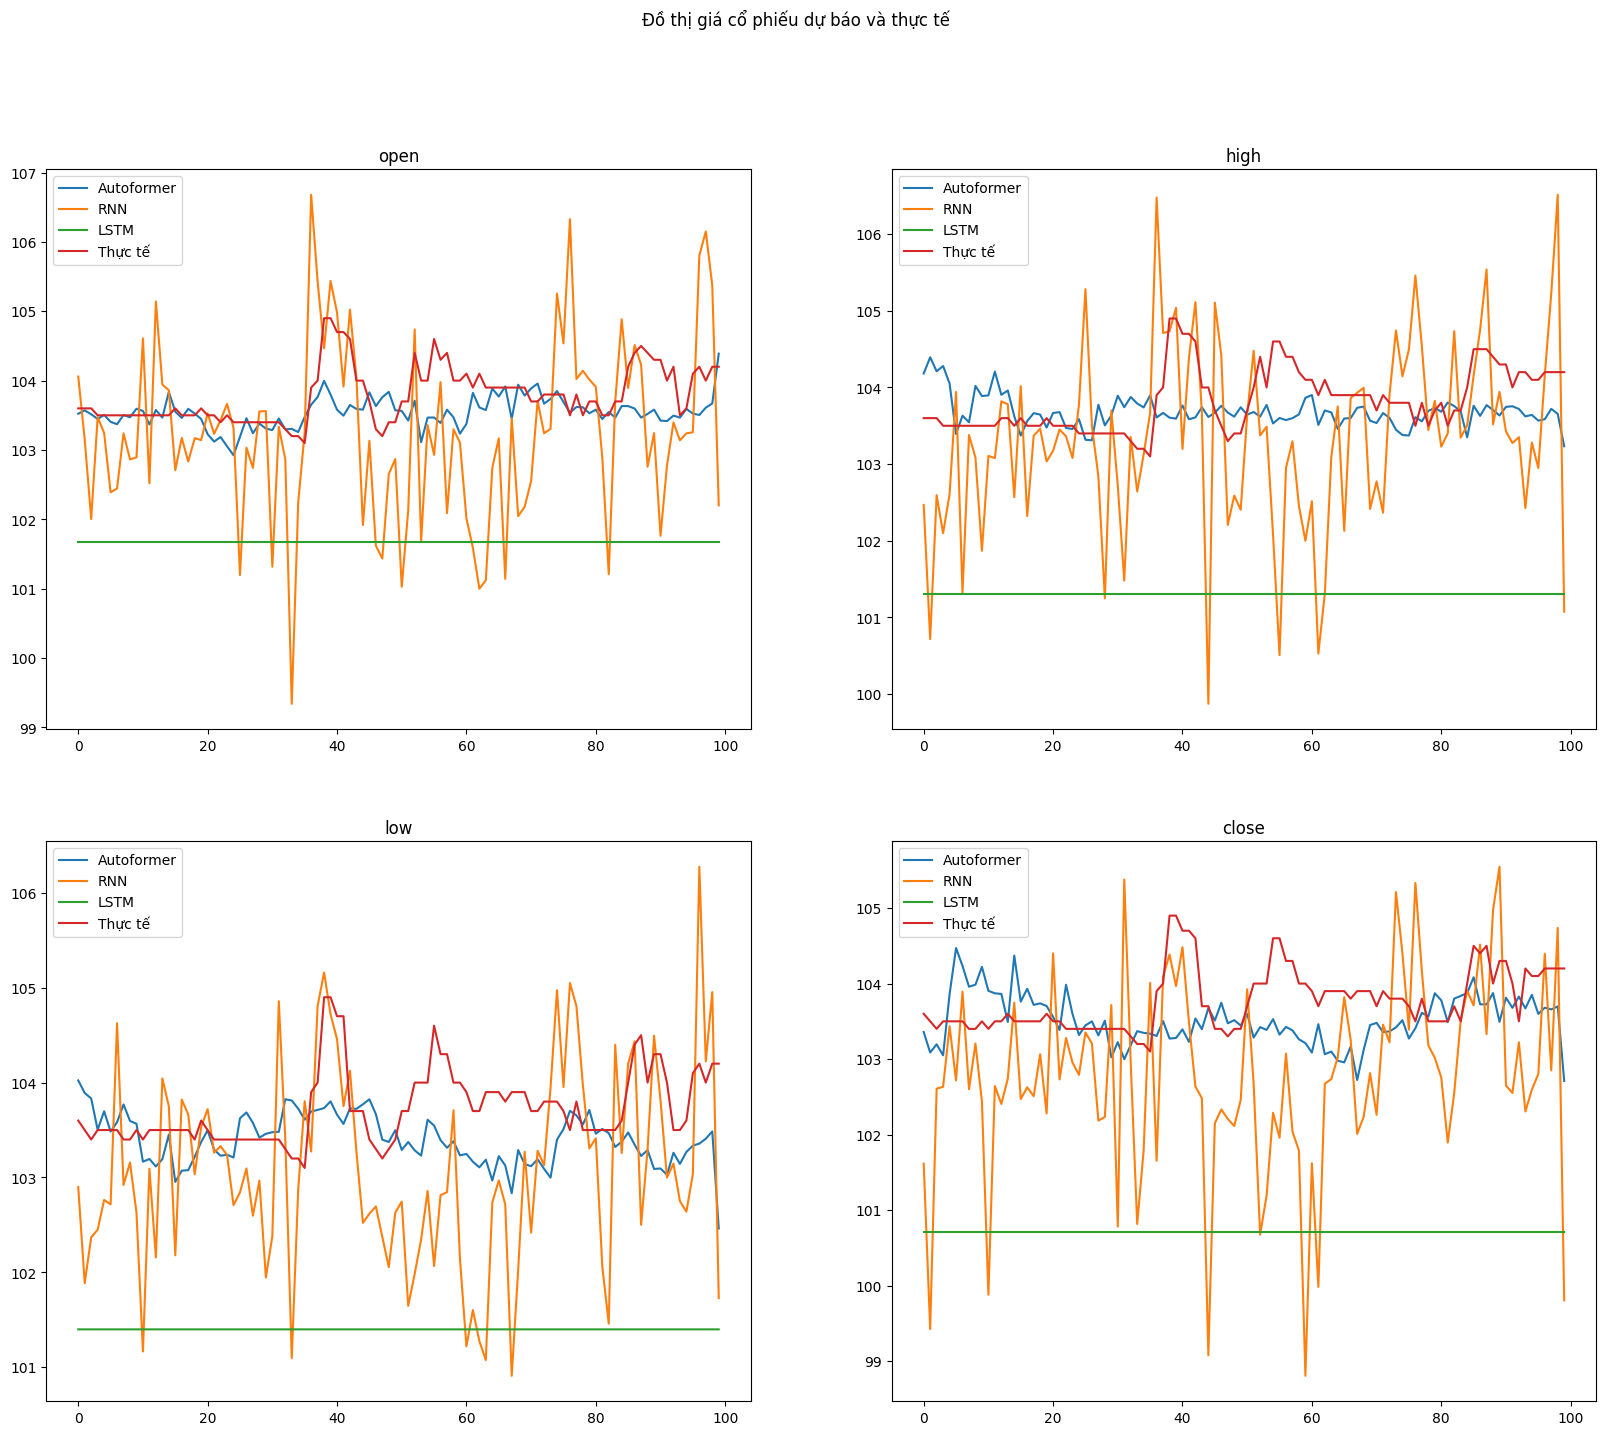

In [202]:
x = data_test1.dataset[16000]
y = data_test2.dataset[16000]
with torch.no_grad():
    pred1 = model1(x[0].unsqueeze(0),x[2].unsqueeze(0), x[1].unsqueeze(0), x[3].unsqueeze(0)).squeeze(0)
    #pred1 = pred1[1:, :] - pred1[:-1,:]
    pred2 = model2(y[0].unsqueeze(0)).squeeze(0)
    #pred2 = pred2[1:, :] - pred2[:-1,:]
    pred3 = model3(y[0].unsqueeze(0)).squeeze(0)
    #pred3 = pred3[1:, :] - pred3[:-1,:]
true = x[1][-100:, : ] #-  x[1][-99:, : ] 
plot(pred1, pred2, pred3, true) 